# Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/My Drive/Coding/idea/modules/
%cd runscr/

/content/drive/My Drive/Coding/idea/modules
/content/drive/My Drive/Coding/idea/modules/runscr


# Setup

## Import necessary libraries

In [2]:
# Import importlib to reload modules and sys and os to add the path for other imports
import importlib
import sys
import os

# Append the parent directory to the path to import the necessary modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import the utilities and the dataloader
from utils import selfutil, inferutil
from classes import SpreadsheetDataLoader, TestRNN

# Now reload the modules to ensure they are up-to-date
importlib.reload(selfutil)
importlib.reload(inferutil)
importlib.reload(SpreadsheetDataLoader)
importlib.reload(TestRNN)

# Import the funcs needed from utils
from utils.selfutil import get_vocabulary, create_embeddings, to_gpu
from utils.inferutil import infer_one, infer_full, thresh_study

# Import the SpreadsheetDataLoader class
from classes.SpreadsheetDataLoader import SpreadsheetDataLoader
from classes.TestRNN import TestRNN

# Other regular imports
import torch.nn as nn
import torch
from tqdm import tqdm
import gc
import os
import pandas as pd
import math
import time
import numpy as np
import random
from sklearn.metrics import precision_score, recall_score, f1_score

# Setup device as a global constant
devstr = "cuda:0" # "cpu"
gpu = False if (devstr == 'cpu') else True
DEVICE = 'cpu' if (devstr == 'cpu') else (torch.device(devstr if torch.cuda.is_available() else 'cpu') if devstr else torch.cuda.current_device())
print(DEVICE)

cuda:0


# Vocab and DataLoader

## Vocabulary

Get the vocabulary object from the helper function as well as the processed file paths.

In [8]:
# Set the directory containing the spreadsheets
data_dir = '../data/train2/'

# Get the list of file paths
spreadsheet_vocab,file_paths = get_vocabulary(data_dir)

# Print info
print(f'\n\nVocabulary size: {len(spreadsheet_vocab._word2idx)}')
print(f'Files Processed: {len(file_paths)}')

PARA - Processing Files:   0%|          | 0/804 [00:00<?, ?it/s]



Vocabulary size: 105105
Files Processed: 804


## Word Embeddings

Create the vector representation for each word in the vocabulary using Glove that represents each word with a 50-dimensional vector else makes it a normally distributed random vector.

**NOTE**: You keep confusing word embeddings with words vectors, they are used interchangeably

In [9]:
# Create the embeddings for each word in the vocabulary and view info
spreadsheet_wvs = create_embeddings(spreadsheet_vocab)
print(f'Word Embeddings Shape: {spreadsheet_wvs.shape}')
print(f'\nExample Embedding for <unk> at index 0:\n{spreadsheet_wvs[0]}')

  0%|          | 0/105105 [00:00<?, ?it/s]

Word Embeddings Shape: torch.Size([105105, 50])

Example Embedding for <unk> at index 0:
tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487,  0.6920, -0.3160, -2.1152,
         0.3223, -1.2633,  0.3500,  0.3081,  0.1198,  1.2377,  1.1168, -0.2473,
        -1.3527, -1.6959,  0.5667,  0.7935,  0.5988, -1.5551, -0.3414,  1.8530,
         0.7502, -0.5855, -0.1734,  0.1835,  1.3894,  1.5863,  0.9463, -0.8437,
        -0.6136,  0.0316,  1.0554,  0.1778, -0.2303, -0.3918,  0.5433, -0.3952,
         0.2055, -0.4503,  1.5210,  3.4105, -1.5312, -1.2341,  1.8197, -0.5515,
        -1.3253,  0.1886])


## Data Loader

DataLoader standardizes the data into uniform batches and we will be represent each spreadsheet as a 100x100x32 LongTensor because we standardize rows and columns as 100x100 and for each cell allow exactly 32 tokens. Therefore each index in x_tok list will be for a single spreadsheet.

In [10]:
# Create the SpreadsheetDataLoader object with the vocabulary and file paths and view
#check_loader = SpreadsheetDataLoader(file_paths, spreadsheet_vocab)
check_loader = SpreadsheetDataLoader(file_paths, spreadsheet_vocab)
print(f'Spreadsheets Processed: {len(check_loader)}')
print(f'x_tok Tensor Shape: {check_loader.x_tok[0].shape}')
print(f'y_tok Tensor Shape: {check_loader.y_tok[0].shape}')

Processing files: 100%|██████████| 804/804 [01:30<00:00,  8.93it/s]


Spreadsheets Processed: 804
x_tok Tensor Shape: torch.Size([100, 100, 32])
y_tok Tensor Shape: torch.Size([100, 100, 17])


Check the DataLoader with model by using a single file

In [ ]:
# # Create a DataLoader from your check_loader
# test_loader = torch.utils.data.DataLoader(check_loader, batch_size=5, shuffle=False)

# # Get one batch from the DataLoader
# batch = next(iter(test_loader))

# # Move the extracted x_tok to gpu
# exfile = to_gpu(batch['x_tok'],1)

# # Define a new neural network model to be trained and transfer it to GPU
# hidden_state_dim = 100
# rnn_layers = 2
# rnn_model = to_gpu(TestRNN(hidden_state_dim, rnn_layers, spreadsheet_wvs),1)

# # Observe the model
# rnn_model.forward(exfile)

# NEW CROSS RNN CHECKER APPROACH



In [6]:
# class CrossRNN(nn.Module):

#     def __init__(self, hidden_state_dim, rnn_layers, embedding_matrix, dropout_rate=0.0, nonlinearity='relu'):
#         super(CrossRNN, self).__init__()

#         # Rows of embed matrix = Each word in the vocabulary
#         self.vocab_size = embedding_matrix.shape[0]  # vocab_size = 34057

#         # Cols of embed matrix = Length of each embedding vector
#         self.embedding_dim = embedding_matrix.shape[1]  # embed_dim = 50

#         # The dimension of the hidden state vector 'h' for each step/token
#         self.hidden_dim = hidden_state_dim  # hid_dim = 100

#         # Number of recurrent layers we will use
#         self.rnn_layers = rnn_layers  # rnn_layers = 2

#         # Creates an embedding layer from the pre-trained embedding matrix that maps input tokens to their corresponding word vectors
#         # If freezing then embeddings don't change during training, we need False because we need them to finetune to our task
#         self._embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

#         # Randomly zeroes out a percentage of input units determined by dropout_rate for each update during training
#         self._drop = nn.Dropout(dropout_rate)

#         # RNN layer with 'relu' nonlinearity but not managing exploding gradients, dropout and multiple recurrent layers
#         self._rnn = nn.RNN(
#             self.embedding_dim,
#             self.hidden_dim,
#             self.rnn_layers,
#             nonlinearity=nonlinearity,
#             dropout=dropout_rate,
#             batch_first=True
#         )

#         # Linear layer to map the concatenated hidden states to logits (1 to predict bold or not)
#         self._pred = nn.Linear(2 * self.hidden_dim, 1)

#     def cell_hs1(self, x):
#       # Set the manual seed for reproducibility
#       torch.manual_seed(0)

#       # Initialize H_local as a zero tensor with the appropriate shape (num_cells, hidden_dim)
#       H_local = torch.zeros(x.shape[0], x.shape[1] * x.shape[2], self.hidden_dim, device=x.device)  # batch x cells x hidden_dim
#       ans = torch.zeros_like(H_local)  # batch x cells x hidden_dim

#       # DEBUG PRINT
#       print(f'\nInput x [batch x rows x cols x tokens]: {x.shape}')
#       print(f'\nH_local before [batch x cells x hidden]: {H_local.shape}')
#       print(f'\nans initialized [batch x cells x hidden]: {ans.shape}')

#       # Retrieve grid dimensions directly from x
#       rows, cols = x.shape[1], x.shape[2]

#       # Iterate over each cell
#       for cell in tqdm(range(rows * cols)):
#           # Calculate the current row and col based on cell index
#           row = cell // cols
#           col = cell % cols

#           # Extract cell tokens across batches for current cell
#           celltoks_across_batch = x[:, row, col, :]  # batch_size x tokens

#           # Get tokens in embedding dim and apply dropout
#           embedded_toks = self._drop(self._embed(celltoks_across_batch))  # batch_size x tokens x embed_dim

#           # Run RNN on dropout input
#           _, h = self._rnn(embedded_toks)  # rnn_layer x batch_size x hidden_dim

#           # Get the last element
#           h_last = h[-1]

#           # Store hidden state from last layer in H_local at cell location
#           H_local[:, cell, :] = h_last  # batch x cell x hidden_dim

#           # Get combined indices for row and column, excluding the current cell
#           indices = [row * cols + c for c in range(cols) if c != col] + [r * cols + col for r in range(rows) if r != row]

#           # Update ans for the combined row and column indices with h_last
#           ans[:, indices, :] += h_last.unsqueeze(1)  # Add h_last to all row and column cells except the current cell


#           # DEBUG PRINT for the first cell only
#           if cell == 0:
#               print(f'\n-----------------------------------------')
#               print(f'\nInside Cell {cell}\nRow {row}, Col {col}')
#               print(f'\nCell Across [batch x tokens]: {celltoks_across_batch.shape}')
#               print(f'\nCell Embedded Toks [batch x tokens x embed]: {embedded_toks.shape}')
#               print(f'\nRNN H [rnn_layers x batch x hidden]: {h.shape}')
#               print(f'\nLast Layer H [batch x hidden]: {h_last.shape}')
#               print(f'\nindices [rows + cols - 2]: {len(indices)}\n{indices}')

#           # Delete intermediate tensors to free up memory
#           del celltoks_across_batch, embedded_toks, h

#       # DEBUG PRINT
#       print(f'\nFinal answer [batch x cells x hidden]: {ans.shape}')

#       return ans

#     # Forward function
#     def forward(self, x):

#         # Set the manual seed
#         torch.manual_seed(0)

#         # Global hidden states containing info around current cell already on gpu
#         # Across batches for each cell
#         H_global = self.cell_hs(x) # batch_size x cells x hidden_dim

#         # Tensor to store the full macro cube of size batch x rows x cols
#         S_cube = torch.zeros((x.shape[0], x.shape[1], x.shape[2]), device=x.device)

#         # DEBUG PRINT
#         print(f'\nInput x {x.shape}')
#         print(f'\nInitial H_global [batch x cells x hidden]: {H_global.shape}')
#         print(f'\nInitial S_cube [batch x row x col]: {S_cube.shape}')

#         # Loop through all rows x cols cells
#         for cell in tqdm(range(x.shape[1] * x.shape[2]),desc="Doing forward"):

#             # Extract global context around cell
#             H_cell = H_global[:, cell, :]

#             # Get the current row and col
#             row = cell // x.shape[2]
#             col = cell % x.shape[2]

#             # Extract cell tokens across batches for current cell
#             celltoks_across_batch = x[:, row, col, :] # batch_size x tokens

#             # Get tokens in embedding dim and apply dropout
#             embedded_toks = self._drop(self._embed(celltoks_across_batch)) # batch_size x tokens x embed_dim

#             # Get output feature from last rnn layer for each token
#             z, _ = self._rnn(embedded_toks) # batch_size x tokens x hidden_dim

#             # Get z for last token across all batches and hidden dim
#             z_lasttok = z[:, -1, :] # batch_size x hidden_dim

#             # Concatenate global/local context of cell along first dim batch_size then apply dropout
#             concat_hs = self._drop(torch.cat((z_lasttok, H_cell), dim = 1)) # batch_size x (2 * hidden_dim)

#             # Reshaped fit into S_cube
#             S_cube[:, row, col] = self._pred(concat_hs).view(-1) # batch_size

#             # DEBUG PRINT
#             if cell == 0:
#                 print(f'\nInside Cell {cell}\nRow {row}, Col {col}')
#                 print(f'\nCell Across: {celltoks_across_batch.shape}')
#                 print(f'\nCell Embedded Toks: {embedded_toks.shape}')
#                 print(f'\nRNN Z: {z.shape}')
#                 #print(f'\nRNN H: {h.shape}')
#                 print(f'\nH_cell global HS for cell: {H_cell.shape}')
#                 print(f'\nRNN Z Last Token: {z_lasttok.shape}')
#                 print(f'\nConcatenated HS: {concat_hs.shape}')
#                 #print(f'\nPredictions: {preds.shape}\n preds')
#                 print(f'\nPredictions Reshaped: {S_cube[:, row, col].shape}:\n{S_cube[:, row, col]}')


#             # Delete intermediate tensors to free up memory
#             del celltoks_across_batch
#             del embedded_toks
#             del z
#             del z_lasttok
#             del H_cell
#             del concat_hs

#         # DEBUG PRINT
#         print(f'\nFinal S_cube {S_cube.shape}:\n{S_cube}')

#         # Delete H_global finally
#         del H_global

#         # Return the final S_cube
#         return S_cube

# # Create a DataLoader from your check_loader
# test_loader = torch.utils.data.DataLoader(check_loader, batch_size=1, shuffle=False)

# # Get one batch from the DataLoader
# batch = next(iter(test_loader))

# # Move the extracted x_tok to gpu
# exfile = batch['x_tok'].to(DEVICE)

# # Define a new neural network model to be trained and transfer it to GPU
# hidden_state_dim = 100
# rnn_layers = 2
# cross_model = CrossRNN(hidden_state_dim, rnn_layers, spreadsheet_wvs).to(DEVICE)

# # Observe the model
# cross_result = cross_model.forward(exfile)

# # Check if the tensors are approximately equal
# tolerance = 3e-1
# are_equal = torch.allclose(cross_result, result2, atol=tolerance)
# print(f"Tensors are approximately equal within tolerance {tolerance}: {are_equal}")

# # Calculate the average difference between the two results
# avg_difference = torch.mean(torch.abs(cross_result - result2)).item()
# print(f"Average absolute difference between cell_hs and cell_hs2 results: {avg_difference}")

In [6]:
import torch
import torch.nn as nn

class CrossRNN(nn.Module):

    def __init__(self, hidden_state_dim, rnn_layers, embedding_matrix, dropout_rate=0.05, nonlinearity='relu'):
        super(CrossRNN, self).__init__()

        # Rows of embed matrix = Each word in the vocabulary
        self.vocab_size = embedding_matrix.shape[0]  # vocab_size = 34057

        # Cols of embed matrix = Length of each embedding vector
        self.embedding_dim = embedding_matrix.shape[1]  # embed_dim = 50

        # The dimension of the hidden state vector 'h' for each step/token
        self.hidden_dim = hidden_state_dim  # hid_dim = 100

        # Number of recurrent layers we will use
        self.rnn_layers = rnn_layers  # rnn_layers = 2

        # Creates an embedding layer from the pre-trained embedding matrix that maps input tokens to their corresponding word vectors
        # If freezing then embeddings don't change during training, we need False because we need them to finetune to our task
        self._embed = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        # Randomly zeroes out a percentage of input units determined by dropout_rate for each update during training
        self._drop = nn.Dropout(dropout_rate)

        # RNN layer with 'relu' nonlinearity but not managing exploding gradients, dropout and multiple recurrent layers
        self._rnn = nn.RNN(
            self.embedding_dim,
            self.hidden_dim,
            self.rnn_layers,
            nonlinearity=nonlinearity,
            dropout=dropout_rate,
            batch_first=True
        )

        # Linear layer to map the concatenated hidden states to logits (1 to predict bold or not)
        self._pred = nn.Linear(2 * self.hidden_dim, 1)

    def cell_hs(self, x):
      # Set the manual seed for reproducibility
      torch.manual_seed(0)

      # Initialize H_local as a zero tensor with the appropriate shape (num_cells, hidden_dim)
      H_global = torch.zeros(x.shape[0], x.shape[1] * x.shape[2], self.hidden_dim, device=x.device)  # batch x cells x hidden_dim

      # Retrieve grid dimensions directly from x
      rows, cols = x.shape[1], x.shape[2]

      # Iterate over each cell
      for cell in range(rows * cols):

          # Update ans for the combined row and column indices with h_last
          H_global[
              :,
              [(cell // cols) * cols + c for c in range(cols) if c != (cell % cols)] + [r * cols + (cell % cols) for r in range(rows) if r != (cell // cols)],
              :
              ] += self._rnn(self._drop(self._embed(x[:, cell // cols, cell % cols, :])))[1][-1].unsqueeze(1)  # Add h_last to all row and column cells except the current cell

      return H_global

    # Forward function
    def forward(self, x):

        # Global hidden states containing info around current cell already on gpu
        # Across batches for each cell
        H_global = self.cell_hs(x) # batch_size x cells x hidden_dim

        # Tensor to store the full macro cube of size batch x rows x cols
        S_cube = torch.zeros((x.shape[0], x.shape[1], x.shape[2]), device=x.device)


        # Loop through all rows x cols cells
        for cell in range(x.shape[1] * x.shape[2]):


            # Concatenate global/local context of cell along first dim batch_size then apply dropout
            S_cube[:, cell // x.shape[2], cell % x.shape[2]] =self._pred(
                self._drop(
                    torch.cat(
                        (
                            self._rnn(
                                self._drop(
                                    self._embed(x[:, cell // x.shape[2], cell % x.shape[2], :])
                                )
                            )[0][:, -1, :],
                            H_global[:, cell, :]
                        ),
                        dim = 1
                    )
                )
            ).view(-1)


        # Delete H_global finally
        del H_global

        # Return the final S_cube
        return S_cube

# Training Function

## To train the normal RNN of full context

In [9]:
def train_test(model, train_loader, batch_size=8, lr=1.4e-5, mu=0.25, max_epochs=4, patience=1, save_int = 2, save_dir='../models/'):
    """
    Train the model for 1 batch, print the length of the train_loader, the training loss, and average training loss.
    """

    # Check if save_int > 0 and save_dir exists
    if save_int > 0 and not os.path.exists(save_dir):
        raise ValueError(f"Directory '{save_dir}' DNE")

    # Define the path where to save model and logfile
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(save_dir, f"rnn_normal_big_{timestamp}.pth")
    log_file = os.path.join(save_dir, f"rnn_normal_big_{timestamp}.txt")

    # Setup optimizer
    opt = torch.optim.Adagrad(model.parameters(), lr=lr)

    # Convert incoming training DataLoader into batches
    batch_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size, shuffle=True)

    # Calculate the class imbalance (ratio of non-bold to bold cells)
    num_bold_cells = sum((batch['y_tok'][:, :, :, 6] == 1).sum() for batch in batch_loader)

    # Binary Cross-Entropy Loss with Logits
    loss_fn = nn.BCEWithLogitsLoss(

        pos_weight = torch.tensor(

            [
                (
                    (len(batch_loader) * batch_size * 100 * 100) - num_bold_cells
                ) / num_bold_cells
            ],

            dtype = torch.float
        ).to(DEVICE)
    )

    # Define the starting epoch
    epoch = 0

    # Define the best average training loss, perplexity as inf max value and epoch as 0
    best_avgtrloss = float('inf')
    best_perp = float('inf')
    best_epoch = 0

    # Epochs without improvement counter and flag for training
    nimp_ctr = 0; training = True

    # Loop while model is in training mode and the epoch is less than max_epochs given
    while training and (epoch < max_epochs):

        # Print the epoch number and write to file also
        print(f'Epoch {epoch}')
        if save_int > 0:
            with open(log_file, 'a') as log:
                log.write(f"\nEpoch {epoch}\n")

        # Turn on training mode which enables dropout.
        model.train()

        # Initialize training loss
        curr_trloss = 0

        # Loop through the batches in batch_loader
        for i, batch in enumerate(tqdm(batch_loader, desc =f'Batch Processing')):

            # Clear any remaining gradients
            model.zero_grad()

            # Compute the loss
            loss = loss_fn(

                model(

                    batch['x_tok'].to(DEVICE)

                ).view(-1),

                batch['y_tok'][:, :, :, 6].to(DEVICE).view(-1).float() # Actual labels from dataloader

            )

            # Accumulate the training loss
            curr_trloss += loss.detach().cpu().item()

            # Compute the gradients of the model parameters by backpropagating the loss
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=mu)

            # Update the model parameters
            opt.step()

            # Clear memory
            del loss


        # Calculate average training loss for this epoch
        curr_avgtrloss = curr_trloss / len(batch_loader)

        # Perplexity = e^(loss/(num_batches x batch_size x cells))
        curr_perp = math.exp(curr_trloss/(len(batch_loader) * batch_size * 10000))

        # Print the average training loss, perplexity for this current epoch and write to file
        print(f'Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}')
        if save_int > 0:
            with open(log_file, 'a') as log:
                log.write(f'Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}\n')

        # Save the model and log if current epoch is a multiple of save_int
        if save_int > 0 and (epoch + 1) % save_int == 0:
            torch.save(model.state_dict(), model_path)
            print(f"Model Saved")
            with open(log_file, 'a') as log: log.write(f"Model Saved\n")

        # Update the best loss, perplexity, epoch if current is best
        best_perp, best_avgtrloss, best_epoch, nimp_ctr = (
            (
                curr_perp, curr_avgtrloss, epoch, 0
            ) if curr_perp < best_perp
            else (
                best_perp, best_avgtrloss, best_epoch, nimp_ctr + 1
            )
        )

        # Check if epochs without improvement have cross the patience threshold
        if nimp_ctr >= patience:

            # If they have then print early stopping message
            print(f"\nEARLY STOP Epoch {epoch}, Best: Epoch = {best_epoch}, Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")
            if save_int > 0:
                with open(log_file, 'a') as log:
                    log.write(f"\nEARLY STOP Epoch {epoch}, Best: Epoch = {best_epoch}, Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")
            training = False


        # Increment the epoch and print a new line
        epoch += 1
        print()

    # Save model and log at the end of training (or early stopping)
    if save_int > 0:
        torch.save(model.state_dict(), model_path)

    # Print training complete message
    print(f"\nTRAINING DONE Best: Epoch = {best_epoch}, Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")
    if save_int > 0:
        with open(log_file, 'a') as log:
            log.write(f"\nTRAINING DONE Best: Epoch = {best_epoch}, Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")

    # Return trained model at the end
    return model

In [10]:
# Define the params
rnn_layers = 2; hidden_dim = 100

# Define the model
rnn_model = TestRNN(hidden_dim, rnn_layers, spreadsheet_wvs).to(DEVICE)

# Call the function to train the model
trained_rnnmodel = train_test(
    rnn_model, check_loader,
    batch_size=32, lr=5.6e-5, mu=0.25, max_epochs=6, patience=2,
    save_int=2, save_dir='../models/'
)

Epoch 0


Batch Processing: 100%|██████████| 26/26 [13:38<00:00, 31.47s/it]


Train Loss: 515.7557361309345, Perplexity: 1.001613036221046

Epoch 1


Batch Processing: 100%|██████████| 26/26 [13:30<00:00, 31.17s/it]


Train Loss: 168.84930097139798, Perplexity: 1.00052779329943
Model Saved

Epoch 2


Batch Processing: 100%|██████████| 26/26 [13:30<00:00, 31.16s/it]


Train Loss: 107.36788030771109, Perplexity: 1.000335580920645

Epoch 3


Batch Processing: 100%|██████████| 26/26 [13:30<00:00, 31.17s/it]


Train Loss: 99.51996817955605, Perplexity: 1.000311048266044
Model Saved

Epoch 4


Batch Processing: 100%|██████████| 26/26 [13:29<00:00, 31.13s/it]


Train Loss: 94.38875902616061, Perplexity: 1.0002950083783722

Epoch 5


Batch Processing: 100%|██████████| 26/26 [13:30<00:00, 31.17s/it]

Train Loss: 90.50840994027945, Perplexity: 1.0002828787837228
Model Saved


TRAINING DONE Best: Epoch = 5, Train Loss = 90.50840994027945, Perplexity = 1.0002828787837228


## To train the Cross RNN of Row+Col context

In [11]:
def train_cross(model, train_loader, batch_size=8, lr=1.4e-5, mu=0.25, max_epochs=4, patience=1, save_int = 2, save_dir='../models/'):
    """
    Train the model for 1 batch, print the length of the train_loader, the training loss, and average training loss.
    """

    # Check if save_int > 0 and save_dir exists
    if save_int > 0 and not os.path.exists(save_dir):
        raise ValueError(f"Directory '{save_dir}' DNE")

    # Define the path where to save model and logfile
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    model_path = os.path.join(save_dir, f"rnn_cross_big_{timestamp}.pth")
    log_file = os.path.join(save_dir, f"rnn_cross_big_{timestamp}.txt")

    # Setup optimizer
    opt = torch.optim.Adagrad(model.parameters(), lr=lr)

    # Convert incoming training DataLoader into batches
    batch_loader = torch.utils.data.DataLoader(train_loader, batch_size=batch_size, shuffle=True)

    # Calculate the class imbalance (ratio of non-bold to bold cells)
    num_bold_cells = sum((batch['y_tok'][:, :, :, 6] == 1).sum() for batch in batch_loader)

    # Binary Cross-Entropy Loss with Logits
    loss_fn = nn.BCEWithLogitsLoss(

        pos_weight = torch.tensor(

            [
                (
                    (len(batch_loader) * batch_size * 100 * 100) - num_bold_cells
                ) / num_bold_cells
            ],

            dtype = torch.float
        ).to(DEVICE)
    )

    # Define the starting epoch
    epoch = 0

    # Define the best average training loss, perplexity as inf max value and epoch as 0
    best_avgtrloss = float('inf')
    best_perp = float('inf')
    best_epoch = 0

    # Epochs without improvement counter and flag for training
    nimp_ctr = 0; training = True

    # Loop while model is in training mode and the epoch is less than max_epochs given
    while training and (epoch < max_epochs):

        # Print the epoch number and write to file also
        print(f'Epoch {epoch}')
        if save_int > 0:
            with open(log_file, 'a') as log:
                log.write(f"\nEpoch {epoch}\n")

        # Turn on training mode which enables dropout.
        model.train()

        # Initialize training loss
        curr_trloss = 0

        # Loop through the batches in batch_loader
        for i, batch in enumerate(tqdm(batch_loader, desc =f'Batch Processing')):

            # Clear any remaining gradients
            model.zero_grad()

            # Compute the loss
            loss = loss_fn(

                model(

                    batch['x_tok'].to(DEVICE)

                ).view(-1),

                batch['y_tok'][:, :, :, 6].to(DEVICE).view(-1).float() # Actual labels from dataloader

            )

            # Accumulate the training loss
            curr_trloss += loss.detach().cpu().item()

            # Compute the gradients of the model parameters by backpropagating the loss
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=mu)

            # Update the model parameters
            opt.step()

            # Clear memory
            del loss


        # Calculate average training loss for this epoch
        curr_avgtrloss = curr_trloss / len(batch_loader)

        # Perplexity = e^(loss/(num_batches x batch_size x cells))
        curr_perp = math.exp(curr_trloss/(len(batch_loader) * batch_size * 10000))

        # Print the average training loss, perplexity for this current epoch and write to file
        print(f'Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}')
        if save_int > 0:
            with open(log_file, 'a') as log:
                log.write(f'Train Loss: {curr_avgtrloss}, Perplexity: {curr_perp}\n')

        # Save the model and log if current epoch is a multiple of save_int
        if save_int > 0 and (epoch + 1) % save_int == 0:
            torch.save(model.state_dict(), model_path)
            print(f"Model Saved")
            with open(log_file, 'a') as log: log.write(f"Model Saved\n")

        # Update the best loss, perplexity, epoch if current is best
        best_perp, best_avgtrloss, best_epoch, nimp_ctr = (
            (
                curr_perp, curr_avgtrloss, epoch, 0
            ) if curr_perp < best_perp
            else (
                best_perp, best_avgtrloss, best_epoch, nimp_ctr + 1
            )
        )

        # Check if epochs without improvement have cross the patience threshold
        if nimp_ctr >= patience:

            # If they have then print early stopping message
            print(f"\nEARLY STOP Epoch {epoch}, Best: Epoch = {best_epoch}, Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")
            if save_int > 0:
                with open(log_file, 'a') as log:
                    log.write(f"\nEARLY STOP Epoch {epoch}, Best: Epoch = {best_epoch}, Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")
            training = False


        # Increment the epoch and print a new line
        epoch += 1
        print()

    # Save model and log at the end of training (or early stopping)
    if save_int > 0:
        torch.save(model.state_dict(), model_path)

    # Print training complete message
    print(f"\nTRAINING DONE Best: Epoch = {best_epoch}, Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")
    if save_int > 0:
        with open(log_file, 'a') as log:
            log.write(f"\nTRAINING DONE Best: Epoch = {best_epoch}, Train Loss = {best_avgtrloss}, Perplexity = {best_perp}")

    # Return trained model at the end
    return model

In [12]:
# Define the params
rnn_layers = 2; hidden_dim = 100

# Define the model
cross_model = CrossRNN(hidden_dim, rnn_layers, spreadsheet_wvs).to(DEVICE)

# Call the function to train the model
trained_crossmodel = train_cross(
    cross_model, check_loader,
    batch_size=32, lr=5.6e-5, mu=0.25, max_epochs=6, patience=2,
    save_int=2, save_dir='../models/'
)

Epoch 0


Batch Processing: 100%|██████████| 26/26 [21:11<00:00, 48.91s/it]


Train Loss: 2.119550008040208, Perplexity: 1.0000066236157112

Epoch 1


Batch Processing: 100%|██████████| 26/26 [21:10<00:00, 48.87s/it]


Train Loss: 1.6797147668324983, Perplexity: 1.000005249122423
Model Saved

Epoch 2


Batch Processing: 100%|██████████| 26/26 [21:10<00:00, 48.87s/it]


Train Loss: 1.6370807748574476, Perplexity: 1.0000051158905074

Epoch 3


Batch Processing: 100%|██████████| 26/26 [21:10<00:00, 48.88s/it]


Train Loss: 1.6076649381564214, Perplexity: 1.0000050239655518
Model Saved

Epoch 4


Batch Processing: 100%|██████████| 26/26 [21:13<00:00, 49.00s/it]


Train Loss: 1.5837670427102308, Perplexity: 1.0000049492842562

Epoch 5


Batch Processing: 100%|██████████| 26/26 [21:12<00:00, 48.95s/it]

Train Loss: 1.563302021760207, Perplexity: 1.0000048853307513
Model Saved


TRAINING DONE Best: Epoch = 5, Train Loss = 1.563302021760207, Perplexity = 1.0000048853307513


# Inference

In a 100x100 spreadsheet where each **cell** is&nbsp; **(0 = NON-BOLD)**&nbsp;or&nbsp;**(1 = BOLD)**, suppose the NON-BOLD/BOLD ratio of cells in **Actual = (9882 / 118)** and **Predicted = (7300 / 2700)**.
<br><br>
- **All Positives (AP) :**  &nbsp;&nbsp;&nbsp;&nbsp; Total BOLD cells in **Actual Data** = **✅ TP + ❌ FN** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = &nbsp;&nbsp;&nbsp;&nbsp; 118
  - **✅ True Positives (TP) :**  &nbsp;&nbsp;&nbsp;&nbsp; BOLD cells **CORRECTLY PREDICTED** as BOLD &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = &nbsp;&nbsp;&nbsp;&nbsp; 118

  - **❌ False Negatives (FN) :**  &nbsp;&nbsp; BOLD cells **INCORRECTLY PREDICTED** as NON-BOLD &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = &nbsp;&nbsp;&nbsp;&nbsp; 0
- **All Negatives (AN) :**  &nbsp;&nbsp;&nbsp;&nbsp; Total NON-BOLD cells in **Actual Data** = **✅ TN + ❌ FP** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = &nbsp;&nbsp;&nbsp;&nbsp; 9882
  - **✅ True Negatives (TN) :** &nbsp;&nbsp;&nbsp;&nbsp;NON-BOLD cells **CORRECTLY PREDICTED** as NON-BOLD &nbsp;&nbsp; = &nbsp;&nbsp;&nbsp;&nbsp; 7300

  - **❌ False Positives (FP) :**  &nbsp;&nbsp;&nbsp;&nbsp; NON-BOLD cells **INCORRECTLY PREDICTED** as BOLD &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = &nbsp;&nbsp;&nbsp;&nbsp; 2582
<br>

Now understand what the metrics **Accuracy, Precision, Recall, F1-Score** would represent
<br><br>
**1. Accuracy :**&nbsp;&nbsp;&nbsp;Proportion of **✅ CORRECTLY PREDICTED** cells (BOLD and NON-BOLD) out of TOTAL CELLS in spreadsheet

<div align="center">
$\frac{\text{TP + TN}}{\text{Total Cells}}\times100\quad=\quad\frac{118 + 7300}{10000}\times100\quad=\quad74.18\%$
</div>

The model correctly classifies 74.18% of cells (7418/10000) as BOLD or NON-BOLD. However, this metric is misleading for judging performance. With a highly imbalanced ratio of NON-BOLD to BOLD cells (9882 to 118), high accuracy could be achieved by simply predicting most cells as NON-BOLD, resulting in a majority correct classification, even if performance on BOLD cells is poor.
<br><br>
**2. Precision :**&nbsp;&nbsp;&nbsp;Proportion of cells **PREDICTED AS BOLD** that are **ACTUALLY BOLD**

<div align="center">
$\frac{\text{TP}}{\text{TP + FP}}\times100\quad=\quad\frac{118}{118 + 2582}\times100\quad=\quad4.37\%$
</div>

Precision of 4.37% means that, out of all cells predicted as BOLD by the model, only 4.37% were actually BOLD in the ground truth. This metric is useful for understanding how accurate the model’s BOLD predictions are. Low precision indicates a high number of **❌ False Positives**, meaning the model frequently predicts cells as BOLD even when they are actually NON-BOLD.

<br><br>
**3. Recall :**&nbsp;&nbsp;&nbsp;Proportion of **ACTUAL BOLD** cells that are **CORRECTLY PREDICTED** as BOLD

<div align="center">
$\frac{\text{TP}}{\text{TP + FN}}\times100\quad=\quad\frac{118}{118 + 0}\times100\quad=\quad100.0\%$
</div>

Recall of 100.0% means that the model correctly identifies 100% of all BOLD cells in the ground truth. This metric is important for understanding the model’s ability to detect BOLD cells. High recall indicates that the model is good at identifying most BOLD cells, though it may still produce **❌ False Positives** by predicting NON-BOLD cells as BOLD.

<br><br>
**4. F1-Score :**&nbsp;&nbsp;&nbsp;Harmonic mean of Precision and Recall, balancing both metrics to provide a single measure of performance. Scores closer to **0.0** indicate poor performance while **0.5 to 0.8** is average, and **above 0.9** is excellent.

<div align="center">
$2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision + Recall}}\quad=\quad2 \times \frac{0.0437 \times 1.0}{0.0437 + 1.0}\quad=\quad0.08$
</div>

An F1-Score of **0.08** indicates a very low balance between the model’s Precision and Recall, suggesting that the model struggles significantly with BOLD cell detection. In this example, the F1-Score shows that the model’s performance on BOLD cell detection is poor, largely due to the very low Precision (high False Positives).


## Setup the model and dataloaders

In [19]:
# Define params common for both models
hidden_state_dim = 100
rnn_layers = 2

# Define RNN model
rnn_model = TestRNN(hidden_state_dim, rnn_layers, spreadsheet_wvs)

# Load the state_dict from the saved file
rnn_state_dict = torch.load('../models/rnn_normal_big_20241106_021544.pth')

# Load the weights into the model
rnn_model.load_state_dict(rnn_state_dict)

# Move the model to GPU
trained_rnnmodel = rnn_model.to(DEVICE)

# Define CrossRNN Model
cross_model = CrossRNN(hidden_state_dim, rnn_layers, spreadsheet_wvs)

# Load the state_dict from the saved file
cross_state_dict = torch.load('../models/rnn_cross_big_20241106_034421.pth')

# Load the weights into the model
cross_model.load_state_dict(cross_state_dict)

# Move the model to GPU
trained_crossmodel = cross_model.to(DEVICE)



<ipython-input-19-1224db14e955>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_state_dict = torch.load('../models/rnn_normal_big_20241106_021544.pth')
<ipython-input-1

In [ ]:
# # Define the directory of small data
# small_dir = '../data/one_bold_small/'

# # List all files in the directory and append the full path
# small_files = [
#     os.path.join(small_dir, filename)
#     for filename in os.listdir(small_dir)
#     if filename.lower().endswith(('.xls', '.xlsx', '.csv'))  # Adjust the file extensions as needed
# ]

# Define the dataloader for inference
# small_loader = SpreadsheetDataLoader(small_files, spreadsheet_vocab)

# Define the directory to be used for inference
infer_dir = '../data/enron/'

# List all files in the directory and append the full path
infer_files = [
    os.path.join(infer_dir, filename)
    for filename in os.listdir(infer_dir)
    if filename.lower().endswith(('.xls', '.xlsx', '.csv'))  # Adjust the file extensions as needed
]

# Define the dataloader for inference
infer_loader = SpreadsheetDataLoader(infer_files, spreadsheet_vocab)

## Evaluation

### Single example from both the infer_loader and actual check_loader


Filename: ../data/enron/richard_sanders_000_1_1_1.pst.44.xls


NB to B ratio: Predicted = 10000:0 | Actual = 9892:108
Accuracy: 98.92% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



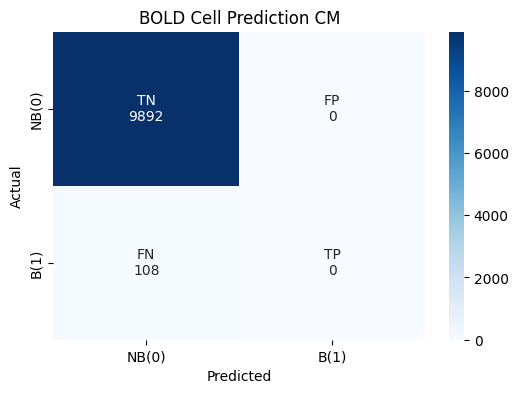


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
infer_one(trained_rnnmodel, infer_loader, 75)


Filename: ../data/enron/richard_sanders_000_1_1_1.pst.44.xls


NB to B ratio: Predicted = 10000:0 | Actual = 9892:108
Accuracy: 98.92% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



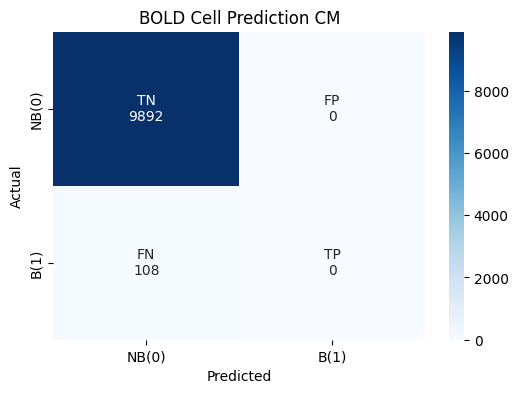


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
infer_one(trained_crossmodel, infer_loader, 75)


Filename: ../data/train2/foodaffordabilitydd.xlsx


NB to B ratio: Predicted = 9914:86 | Actual = 9996:4
Accuracy: 99.18% | Precision: 4.65% | Recall: 100.00% | F1-Score: 0.09



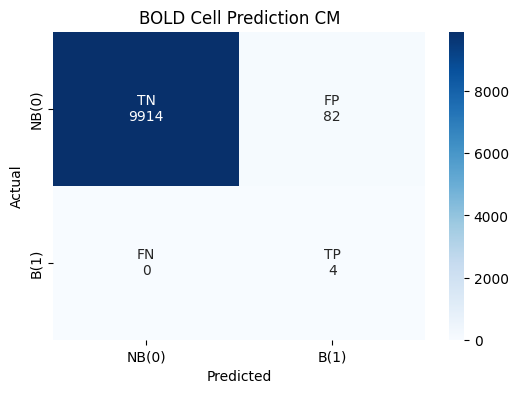


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
infer_one(trained_rnnmodel, check_loader, 72)


Filename: ../data/train2/foodaffordabilitydd.xlsx


NB to B ratio: Predicted = 10000:0 | Actual = 9996:4
Accuracy: 99.96% | Precision: 0.00% | Recall: 0.00% | F1-Score: 0.00



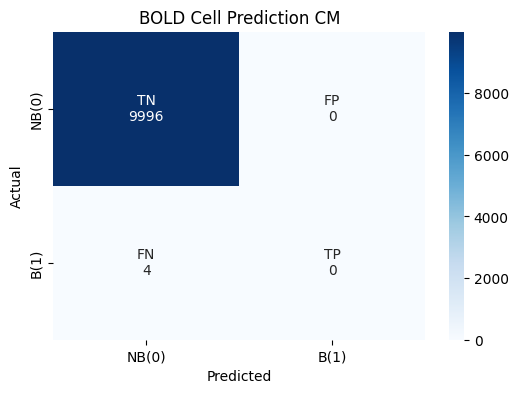


--- Predicted Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



--- Actual Grid (1 = Bold, 0 = Not Bold) ---


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
infer_one(trained_crossmodel, check_loader, 72)

### Subset of 250 examples from both the infer_loader and actual check_loader

Processing files: 100%|██████████| 200/200 [06:22<00:00,  1.91s/it]



--- Average Metrics Across All Files ---

Total Files Processed: 200

NB to B ratio: Predicted = 1998284:1716 | Actual = 1984637:15363
Accuracy: 99.17% | Precision: 1.21% | Recall: 6.50% | F1-Score: 0.02



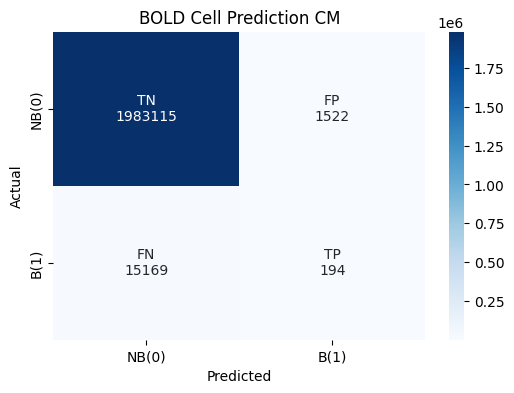

In [16]:
infer_full(trained_rnnmodel, infer_loader)


Processing files: 100%|██████████| 200/200 [16:28<00:00,  4.94s/it]



--- Average Metrics Across All Files ---

Total Files Processed: 200

NB to B ratio: Predicted = 1400575:599425 | Actual = 1984637:15363
Accuracy: 69.26% | Precision: 0.01% | Recall: 0.04% | F1-Score: 0.00



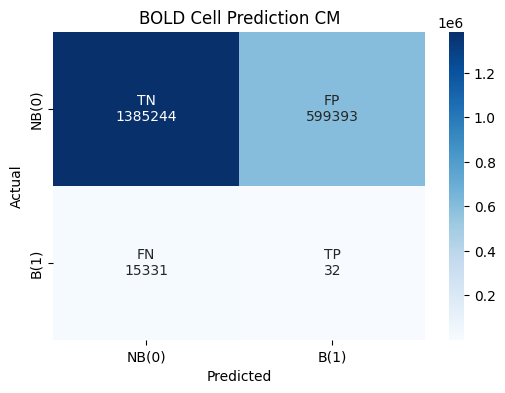

In [23]:
infer_full(trained_crossmodel, infer_loader)


Processing files: 100%|██████████| 200/200 [06:11<00:00,  1.86s/it]



--- Average Metrics Across All Files ---

Total Files Processed: 200

NB to B ratio: Predicted = 1996140:3860 | Actual = 1990511:9489
Accuracy: 99.36% | Precision: 1.85% | Recall: 13.86% | F1-Score: 0.03



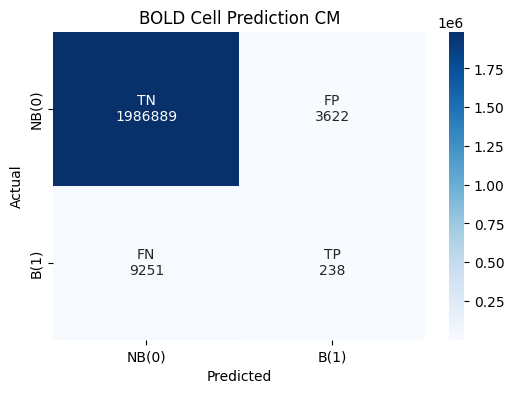

In [24]:
infer_full(trained_rnnmodel, check_loader)


Processing files: 100%|██████████| 200/200 [16:04<00:00,  4.82s/it]



--- Average Metrics Across All Files ---

Total Files Processed: 200

NB to B ratio: Predicted = 1487504:512496 | Actual = 1990511:9489
Accuracy: 73.90% | Precision: 0.03% | Recall: 0.28% | F1-Score: 0.00



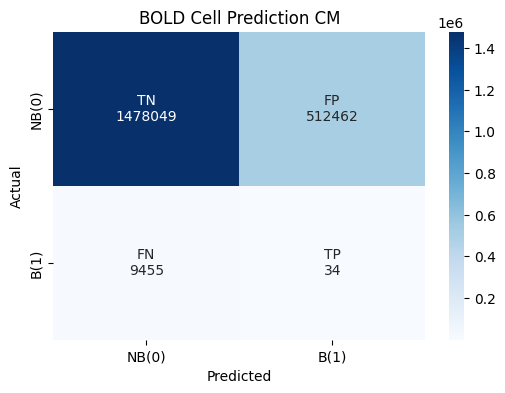

In [25]:
infer_full(trained_crossmodel, check_loader)